In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '7'
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE'] = 'false'


In [2]:
from functools import partial
import jax # jax==0.1.67 / jaxlib==0.1.55
from jax import random, grad, jit, vmap, flatten_util, nn
from jax.experimental import optix
from jax.config import config
import jax.numpy as np

import haiku as hk

from livelossplot import PlotLosses
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
import os
import cv2

import imageio
import json
import pickle

rng = jax.random.PRNGKey(42)

If you do not have jax and jaxlib, install -
* pip install --upgrade jax==0.1.77 jaxlib==0.1.64+cuda110 -f https://storage.googleapis.com/jax-releases/jax_releases.html

# Dataset loader
There are two dataloader below - ShapeNet and Realistic synthetic (Lego)

You should change `DATA_PATH` and `SPLITS_FILE` to the collect path

# Phototourism Data

In [3]:
DATASET = 'sacre'
posedir = f'/mnt/disk2/JYChung/dataset/metaNeRF/phototourism/sacre/' # Directory condtains [bds.npy, c2w_mats.npy, kinv_mats.npy, res_mats.npy]
# imgdir = f'/data/phototourism/sacre/sacre_coeur/dense/images/' # Directory of images

posedata = {}
for f in os.listdir(posedir):
    if '.npy' not in f:
        continue
    z = np.load(os.path.join(posedir, f))
    posedata[f.split('.')[0]] = z
print('Pose data loaded - ', posedata.keys())

# imgfiles = sorted(glob.glob(imgdir + '/*.jpg'))
# print(f'{len(imgfiles)} images')

Pose data loaded -  dict_keys(['bds', 'res_mats', 'kinv_mats', 'c2w_mats'])


In [31]:
posedata['res_mats']

array([[1057,  694],
       [1057,  780],
       [ 785, 1070],
       ...,
       [ 659,  989],
       [1044,  775],
       [1068,  785]])

In [27]:
np.tile(np.array([1,2]), (10,1)).shape

(10, 2)

In [ ]:
def get_example(img_idx, split='train', downsample=4):
    sc = .05
    if 'train' in split:
        img_idx + 25
    if 'val' in split:
        img_idx + 20
    img = imageio.imread(imgfiles[img_idx])[...,:3]/255.
    c2w = posedata['c2w_mats'][img_idx]
    kinv = posedata['kinv_mats'][img_idx]
    c2w = np.concatenate([c2w[:3,:3], c2w[:3,3:4]*sc], -1)
    bds = posedata['bds'][img_idx] * np.array([.9, 1.2]) * sc
    H, W = img.shape[:2]
    i, j = np.meshgrid(np.arange(0,W,downsample), np.arange(0,H,downsample), indexing='xy')
    
    test_images = img[j, i]
    test_rays = get_rays(c2w, kinv, i, j)
    return test_images, test_rays, bds

# ShapeNet Data

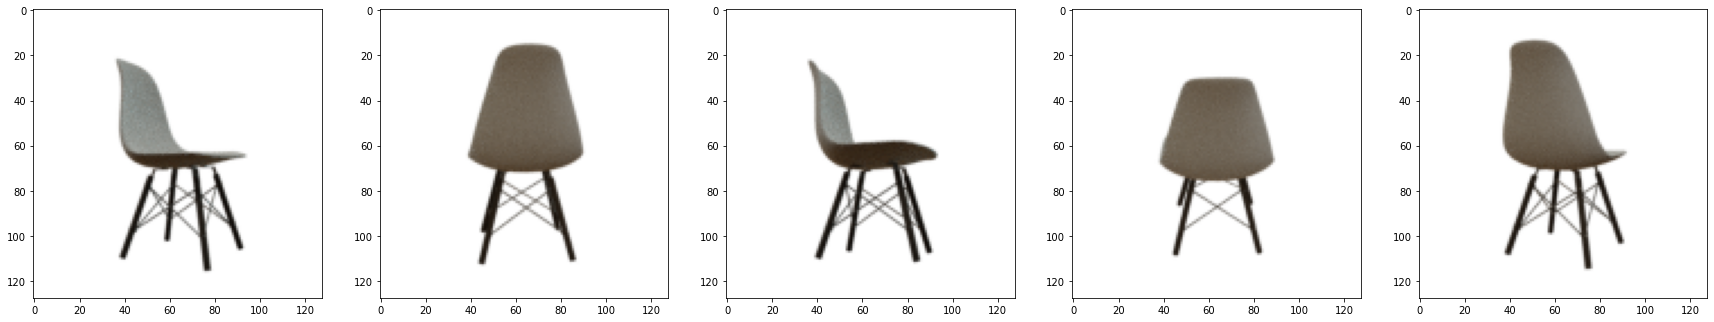

In [3]:
SPLITS_FILE = '/mnt/disk2/JYChung/dataset/metaNeRF/shapenet/chair_splits.json' # Update
DATA_PATH = '/mnt/disk2/JYChung/dataset/metaNeRF/shapenet/chairs/03001627' # Update

import json
import imageio

def load_train_ex(train_ex_dir, key=None):
    
    with open(os.path.join('/', train_ex_dir, 'transforms.json'), 'r') as fp:
        meta = json.load(fp)

    camera_angle_x = float(meta['camera_angle_x'])

    imgs = []
    bkgds = []
    poses = []
    for idx in np.arange(len(meta['frames'])):
        frame = meta['frames'][idx]
        fname = os.path.join(train_ex_dir, os.path.basename(frame['file_path']) + '.png')
        imgs.append(imageio.imread(fname))
        poses.append(np.array(frame['transform_matrix']))
    H, W = imgs[0].shape[:2]
    focal = .5 * W / np.tan(.5 * camera_angle_x)
    imgs = (np.array(imgs) / 255.).astype(np.float32)
    imgs = imgs[...,:3] * imgs[...,-1:] + 1-imgs[...,-1:]
    poses = np.array(poses).astype(np.float32)

    return imgs, poses, [H,W,focal]

with open(SPLITS_FILE, "r") as read_file:
    splits = json.load(read_file)

train_exs = [os.path.join(DATA_PATH, d) for d in sorted(splits['train'])]
test_exs =[os.path.join(DATA_PATH, d) for d in sorted(splits['test'])]
val_exs = [os.path.join(DATA_PATH, d) for d in sorted(splits['val'])]

images, poses, hwf = load_train_ex(train_exs[4], rng)
fig = plt.figure(figsize=(30,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(images[i])

# Lego Data

In [14]:
with open(os.path.join('/mnt/disk2/JYChung/dataset/NeRF_Data/nerf_synthetic/lego','transforms_train.json'), 'r') as fp:
    meta = json.load(fp)

In [18]:
meta['frames'][0].keys()

dict_keys(['file_path', 'rotation', 'transform_matrix'])

(100, 200, 200, 3)
[[-9.9990219e-01  4.1922452e-03 -1.3345719e-02 -5.3798322e-02]
 [-1.3988681e-02 -2.9965907e-01  9.5394367e-01  3.8454704e+00]
 [-4.6566129e-10  9.5403719e-01  2.9968831e-01  1.2080823e+00]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[200, 200, DeviceArray(69.44444, dtype=float32)]


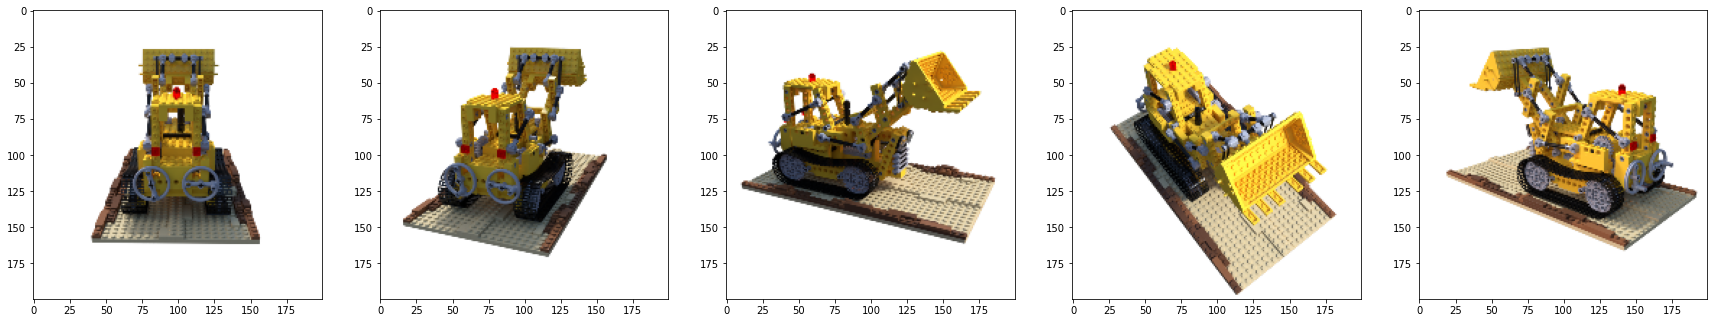

In [3]:
DATA_PATH = '/mnt/disk2/JYChung/dataset/NeRF_Data/nerf_synthetic/lego/' # Update
# Assume that - scene0 scene1 scene2 scene3 scene4 is placed in $DATA_PATH$ folder

import json
import imageio
import cv2

def load_nerf_synthetic(scene_path, type="test", down=4):
    # h,w,f = 800, 800, 1111.11
    with open(os.path.join(DATA_PATH, 'transforms_'+type+'.json'), 'r') as fp:
        meta = json.load(fp)

    camera_angle_x = float(meta['camera_angle_x'])

    imgs = []
    bkgds = []
    poses = []
    img0 = imageio.imread(os.path.join(scene_path, 'r_0.png')) # to get H, W
    H, W = 800//down,800//down#img0.shape[0]//down, img0.shape[1]//down
    for idx in np.arange(len(meta['frames'])):
        frame = meta['frames'][idx]
        fname = os.path.join(scene_path, 'r_'+str(idx)+'.png')
        try:
            imgs.append(cv2.resize(imageio.imread(fname),(H,W)))
            poses.append(np.array(frame['transform_matrix']))
        except:
            continue
    focal = .5 * W / np.tan(.5 * camera_angle_x)/down #1111.11/down #
    imgs = (np.array(imgs) / 255.).astype(np.float32)
    imgs = imgs[...,:3] * imgs[...,-1:] + 1-imgs[...,-1:]
    poses = np.array(poses).astype(np.float32)

    return imgs, poses, [H,W,focal]

num_scene = 5
train_exs =[os.path.join(DATA_PATH, "scene"+str(scene), "train") for scene in range(num_scene)]
# test_exs =[os.path.join(DATA_PATH, "scene"+str(scene), "test") for scene in range(num_scene)]

imgs, poses, hwf = load_nerf_synthetic(scene_path=train_exs[0], type="train", down=4) # scene0, scene1, scene2 ...

fig = plt.figure(figsize=(30,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(imgs[i])
print(imgs.shape)
print(poses[0])
print(hwf)

# Define NeRF Model and Rendering function

In [4]:
def get_rays(H, W, focal, c2w):
    i, j = np.meshgrid(np.arange(W), np.arange(H), indexing='xy')
    dirs = np.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -np.ones_like(i)], -1)
    rays_d = np.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = np.broadcast_to(
        c2w[:3,-1], rays_d.shape)
    return np.stack([rays_o, rays_d], 0)

get_rays = jit(get_rays, static_argnums=(0, 1))
get_ray_batch = jax.vmap(get_rays, in_axes=[None, None, None, 0], out_axes=1)

In [6]:
def render_rays(rnd_input, model, params, rays, N_samples, rand=False, allret=False):
    rays_o, rays_d = rays
    
    near = 2
    far = 6

    # Compute 3D query points
    z_vals = np.linspace(near, far, N_samples) 
    if rand:
        z_vals += random.uniform(rnd_input, shape=list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]
    # print(pts.shape)
    # print(rays_o[...,None,:])
    # viewdirs
    # viewdirs = rays_o/np.linalg.norm(rays_o, axis=1)[0]
    # viewdirs = np.stack((np.arctan2(viewdirs[:,0], viewdirs[:,1]), np.arcsin(viewdirs[:,2])), axis=1)

    # Run network
    # pts_flat = np.reshape(pts, [-1,3])
        
    raw = model.apply(params, pts, rays_o)
    raw = np.reshape(raw, list(pts.shape[:-1]) + [4])
    
    # Compute opacities and colors
    rgb, sigma_a = raw[...,:3], raw[...,3]
    sigma_a = jax.nn.relu(sigma_a)
    rgb = jax.nn.sigmoid(rgb) 
    
    # Do volume rendering
    dists = np.concatenate([z_vals[..., 1:] - z_vals[..., :-1], np.broadcast_to([1e-3], z_vals[...,:1].shape)], -1) 
    alpha = 1. - np.exp(-sigma_a * dists)
    trans = np.minimum(1., 1. - alpha + 1e-10)
    trans = np.concatenate([np.ones_like(trans[...,:1]), trans[...,:-1]], -1)  
    weights = alpha * np.cumprod(trans, -1)
    
    rgb_map = np.sum(weights[...,None] * rgb, -2)
    acc_map = np.sum(weights, -1)    
    rgb_map = rgb_map + (1.-acc_map[...,None]) # white background 
    
    if False:
        rgb_map = rgb_map + (1.-acc_map[..., None])
    
    if not allret:
        return rgb_map
    
    depth_map = np.sum(weights * z_vals, -1) 

    return rgb_map, depth_map, acc_map

def render_fn_inner(rnd_input, model, params, rays, rand, allret, N_samples):
    return render_rays(rnd_input, model, params, rays, N_samples=N_samples, rand=rand, allret=allret)
render_fn_inner = jit(render_fn_inner, static_argnums=(1, 4, 5, 6))

def render_fn(rnd_input, model, params, rays, N_samples, rand):
    chunk = 5
    for i in range(0, rays.shape[1], chunk):
        out = render_fn_inner(rnd_input, model, params, rays[:,i:i+chunk], rand, True, N_samples)
        if i==0:
            rets = out
        else:
            rets = [np.concatenate([a, b], 0) for a, b in zip(rets, out)]
    return rets

In [106]:
class Model(hk.Module):
    def __init__(self):
        super().__init__()
        self.width = 256
        self.depth = 6
        self.use_viewdirs = True
                
    def __call__(self, coords, viewdirs=None):
        coordsh = coords.shape[-2]
        # print("coordsh: ", coords.shape, coordsh)
        coords = np.reshape(coords, [-1,3])
        sh = coords.shape
        if self.use_viewdirs:
            viewdirs /= np.linalg.norm(viewdirs, axis=-1, keepdims=True)
            viewdirs = np.repeat(viewdirs[...,None,:], coordsh, axis=-2)
            viewdirs = np.reshape(viewdirs, (-1,3))
            viewdirs = hk.Linear(output_size=self.width//2)(viewdirs)
            viewdirs = jax.nn.relu(viewdirs)
        coords = np.reshape(coords, [-1,3])
        
        x = np.concatenate([np.concatenate([np.sin(coords*(2**i)), np.cos(coords*(2**i))], axis=-1) for i in np.linspace(0,8,20)], axis=-1)

        for _ in range(self.depth-1):
            x = hk.Linear(output_size=self.width)(x)
            x = jax.nn.relu(x)
            
        if self.use_viewdirs:
            density = hk.Linear(output_size=1)(x)
            # print(x.shape, viewdirs.shape)
            x = np.concatenate([x,viewdirs], axis=-1)
            x = hk.Linear(output_size=self.width)(x)
            x = jax.nn.relu(x)
            rgb = hk.Linear(output_size=3)(x)
            out = np.concatenate([density, rgb], axis=-1)
        else:
            out = hk.Linear(output_size=4)(x)
        out = np.reshape(out, list(sh[:-1]) + [4])
        return out

# Single Train

* `checkpoint_dir` is for save path, please change.
* Note that, the model above is simplified version of nerf (without view direction / small number of layers)
* That is why lego shows much worse result. (if you test with shapeNet dataset, you can get the result like below)

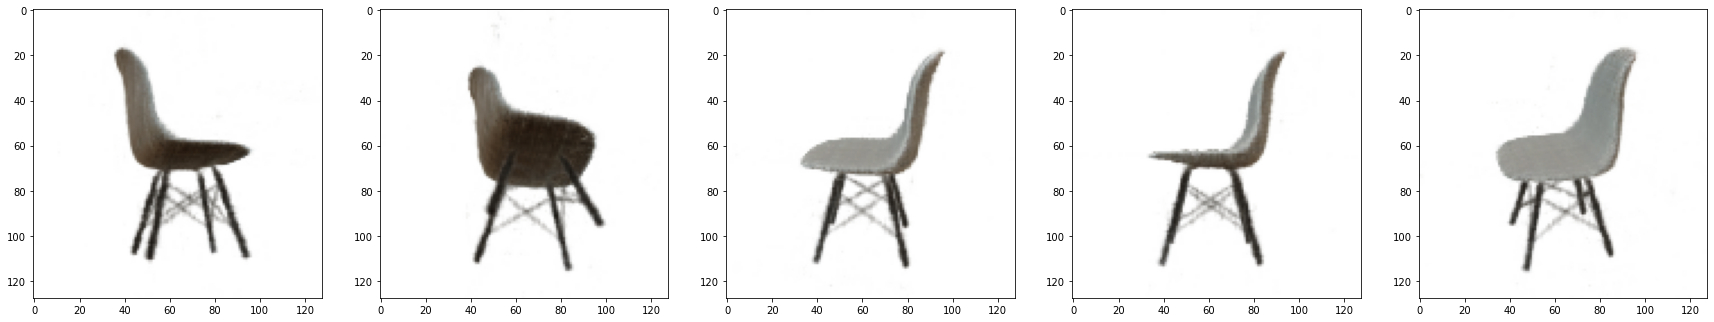

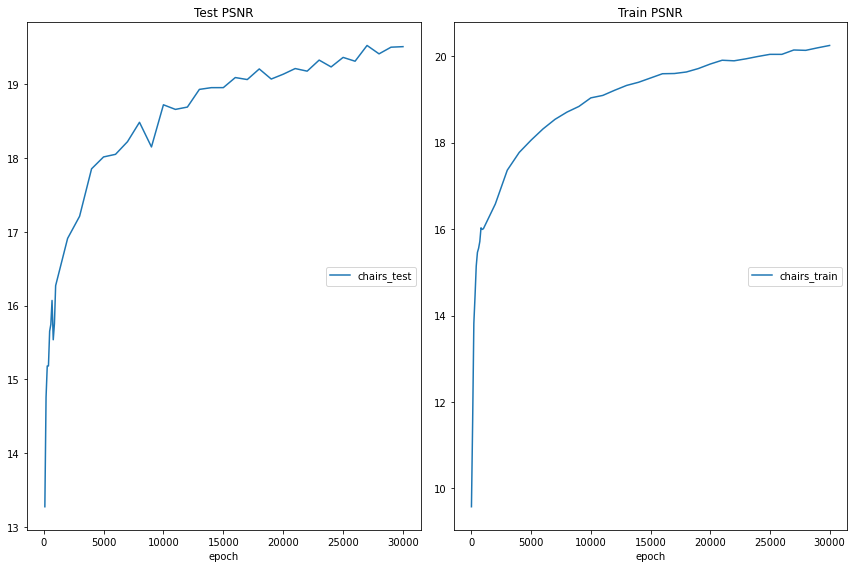

Test PSNR
	chairs_test      	 (min:   13.277, max:   19.523, cur:   19.506)
Train PSNR
	chairs_train     	 (min:    9.577, max:   20.249, cur:   20.249)


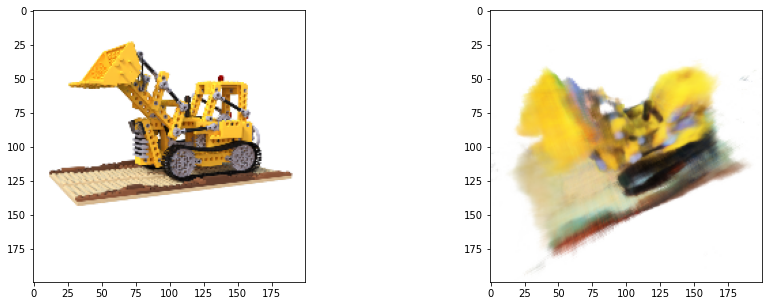

In [107]:
# Training!
plt_groups = {'Train PSNR':[], 'Test PSNR':[]}
plotlosses_model = PlotLosses(groups=plt_groups)

exp_name = 'chairs'
max_iters = 30001
batch_size = 256

inner_update_steps = 1
lr = inner_step_size = 5e-4

# checkpoint_dir = 'checkpoints/checkpoints_singlechair'
checkpoint_dir = 'checkpoints/checkpoints_lego'
os.makedirs(checkpoint_dir, exist_ok=True)

N_samples = 1024

model = hk.without_apply_rng(hk.transform(lambda x, y: Model()(x, y))) #y=None
params = model.init(rng, np.ones((1,3)), np.ones((1,3)))

mse_fn = jit(lambda x, y: np.mean((x - y)**2))
psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))

# update inner model network weights with once step of sgd
@jit
def single_step(rng, images, rays, params, idx):
    def sgd(param, update):
        return param - inner_step_size * update

    def loss_fn(params, rng_inputs):
        idx = random.randint(rng_inputs[0], shape=(batch_size,), minval=0, maxval=images.shape[0])
        image_sub = images[idx,:]
        rays_sub = rays[:,idx,:]

        g = render_rays(rng_inputs[1], model, params, rays_sub, N_samples, rand=True)
        return mse_fn(g, image_sub)

    rng, *rng_inputs = jax.random.split(rng, 3)
    loss, grad = jax.value_and_grad(loss_fn)(params, rng_inputs)
    params = jax.tree_multimap(sgd, params, grad)
    return rng, params, loss

# update inner model network weights inner_update_steps number of times
def update_network_weights(rng, images, rays, params):
    for _ in range(inner_update_steps):
        idx = random.randint(rng, shape=(batch_size,), minval=0, maxval=images.shape[0])
        rng, params, loss = single_step(rng, images, rays, params, idx)
    return rng, params, loss

# update meta model weights based on trained inner model weights
def update_model(rng, params, opt_state, images, rays):
    rng, new_params, model_loss = update_network_weights(rng, images, rays, params)

    def calc_grad(params, new_params):
        return params - new_params

    model_grad = jax.tree_multimap(calc_grad, params, new_params)
    updates, opt_state = opt.update(model_grad, opt_state)
    params = optix.apply_updates(params, updates)
    return rng, params, opt_state, model_loss


opt = optix.adam(lr)
opt_state = opt.init(params)

plt_groups['Train PSNR'].append(exp_name+f'_train')
plt_groups['Test PSNR'].append(exp_name+f'_test')
step = 0
train_psnrs = []
rng = jax.random.PRNGKey(0)

train_size = len(train_exs)
test_psnrs = []

num_test = 5
rng, rng_input = jax.random.split(rng)
# images, poses, hwf = load_train_ex(train_exs[4], rng) # 50 # load_nerf_synthetic
images, poses, hwf = load_nerf_synthetic(scene_path=train_exs[0], type="train", down=4) # scene0, scene1, scene2 ...
train_images, test_images = np.split(images, [images.shape[0]-num_test], axis=0)
train_poses, test_poses = np.split(poses, [images.shape[0]-num_test], axis=0)

for step in tqdm(range(max_iters)):
    rays = get_ray_batch(hwf[0], hwf[1], hwf[2], train_poses)
    rays = np.reshape(rays, (2,-1,3))

    rng, params, opt_state, loss = update_model(rng, params, opt_state, np.reshape(train_images, (-1,3)), rays)
    train_psnrs.append(-10 * np.log10(loss))

    if step == 0:
        plotlosses_model.update({exp_name+'_train':np.mean(np.array(train_psnrs))}, current_step=step)
        train_psnrs = []
    if step != 0 and (step % 1000 == 0 or (step < 1000 and step % 100 == 0)):
        plotlosses_model.update({exp_name+'_train':np.mean(np.array(train_psnrs))}, current_step=step)
        train_psnr = float(np.mean(np.array(train_psnrs)))  
        train_psnrs = []

        test_psnr = []
        for i in range(num_test):
            test_rays = get_rays(hwf[0], hwf[1], hwf[2], test_poses[i])
            test_result = np.clip(render_fn(rng, model, params, test_rays, N_samples, rand=False)[0], 0, 1)
            test_psnr.append(psnr_fn(test_images[i], test_result))

        test_psnr = np.mean(np.array(test_psnr))
        test_psnrs.append(test_psnr)
        plotlosses_model.update({exp_name+'_test':test_psnr}, current_step=step)
        plotlosses_model.send()

        plt.figure(figsize=(15, 5))   
        plt.subplot(1, 2, 1)
        plt.imshow(test_images[0])
        plt.subplot(1, 2, 2)
        plt.imshow(test_result)
        plt.show()
    if step % 10000 == 0 and step != 0:
        pickle.dump(params, open(f"{checkpoint_dir}/{exp_name}_{step}.pkl", 'wb'))

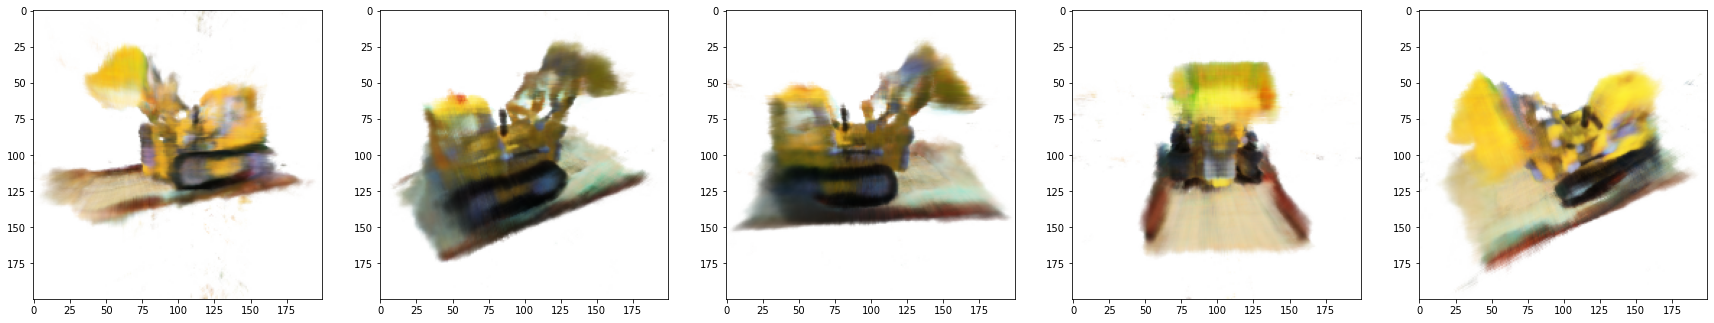

In [115]:
# if step % (max_iters-1) == 0:
fig = plt.figure(figsize=(30, 10))   
for i in range(num_test):
    test_rays = get_rays(hwf[0], hwf[1], hwf[2], test_poses[i])
    test_result = np.clip(render_fn(rng, model, params, test_rays, N_samples, rand=False)[0], 0, 1)
    ax = fig.add_subplot(1, num_test, i+1)
    ax.imshow(test_result)
plt.savefig('legofig'+str(step)+'.png', dpi=300)

# End of Single scene training.
-
-
-

# Meta-Learning 

### From here, we show meta-learing code which is the same with the code of https://github.com/tancik/learnit

# Meta Train

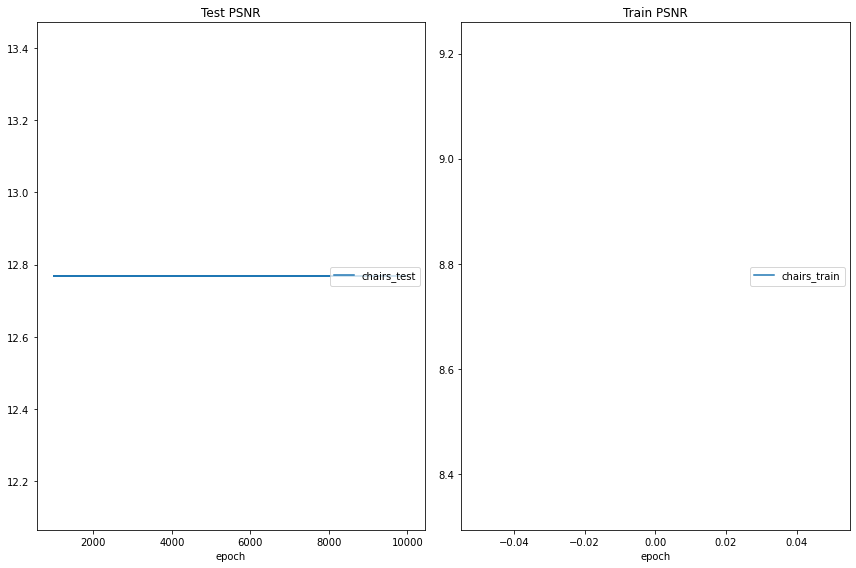

Test PSNR
	chairs_test      	 (min:   12.768, max:   12.768, cur:   12.768)
Train PSNR
	chairs_train     	 (min:    8.777, max:      inf, cur:      inf)


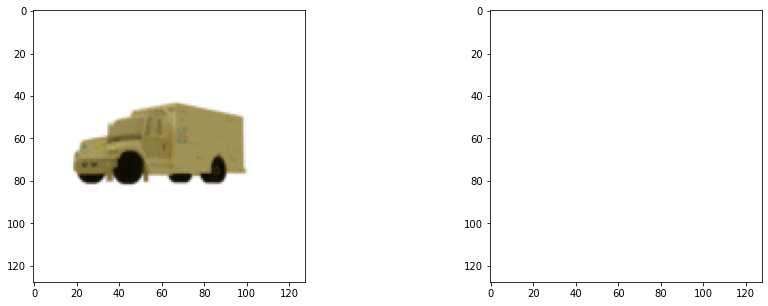

FileNotFoundError: [Errno 2] No such file or directory: 'checkpoints/checkpoints_shapenet//chairs_10000.pkl'

In [11]:
plt_groups = {'Train PSNR':[], 'Test PSNR':[]}
plotlosses_model = PlotLosses(groups=plt_groups)

exp_name = 'chairs'
max_iters = 10001
batch_size = 128

num_views = 25
test_time_views = 1

inner_update_steps = 32
inner_step_size = .5
lr = 5e-4

checkpoint_dir = 'checkpoints/checkpoints_shapenet'

N_samples = 128

model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))
params = model.init(rng, np.ones((1,3)))

test_inner_steps = 128*128 * 4 // batch_size

mse_fn = jit(lambda x, y: np.mean((x - y)**2))
psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))

# update inner model network weights with once step of sgd
@jit
def single_step(rng, images, rays, params, idx):
    def sgd(param, update):
        return param - inner_step_size * update

    def loss_fn(params, rng_inputs):
        idx = random.randint(rng_inputs[0], shape=(batch_size,), minval=0, maxval=images.shape[0])
        image_sub = images[idx,:]
        rays_sub = rays[:,idx,:]

        g = render_rays(rng_inputs[1], model, params, rays_sub, N_samples, rand=True)
        return mse_fn(g, image_sub)

    rng, *rng_inputs = jax.random.split(rng, 3)
    loss, grad = jax.value_and_grad(loss_fn)(params, rng_inputs)
    params = jax.tree_multimap(sgd, params, grad)
    return rng, params, loss

# update inner model network weights inner_update_steps number of times
def update_network_weights(rng, images, rays, params):
    for _ in range(inner_update_steps):
        idx = random.randint(rng, shape=(batch_size,), minval=0, maxval=images.shape[0])
        rng, params, loss = single_step(rng, images, rays, params, idx)
    return rng, params, loss

# update meta model weights based on trained inner model weights
def update_model(rng, params, opt_state, images, rays):
    rng, new_params, model_loss = update_network_weights(rng, images, rays, params)

    def calc_grad(params, new_params):
        return params - new_params

    model_grad = jax.tree_multimap(calc_grad, params, new_params)
    updates, opt_state = opt.update(model_grad, opt_state)
    params = optix.apply_updates(params, updates)
    return rng, params, opt_state, model_loss

# train meta model inner_steps number of times to evaluate meta parameters
def update_network_weights_test(rng, images, rays, params, inner_steps):
    lowest_loss = 1e7
    for _ in range(inner_steps):
        idx = random.randint(rng, shape=(batch_size,), minval=0, maxval=images.shape[0])
        rng, params, loss = single_step(rng, images, rays, params, idx)
        if loss < lowest_loss:
            lowest_loss = loss
    return rng, params, lowest_loss


opt = optix.adam(lr)
opt_state = opt.init(params)

plt_groups['Train PSNR'].append(exp_name+f'_train')
plt_groups['Test PSNR'].append(exp_name+f'_test')
step = 0
train_psnrs = []
rng = jax.random.PRNGKey(0)

train_size = len(train_exs)
test_psnrs = []

for step in range(max_iters):
    try:
        rng, rng_input = jax.random.split(rng)
        img_idx = random.randint(rng, shape=(1,), minval=0, maxval=train_size)
        images, poses, hwf = load_train_ex(train_exs[img_idx[0]], rng)

        images = images[:num_views]
        poses = poses[:num_views]
    except:
        continue
    images = np.reshape(images, (-1,3))

    rays = get_ray_batch(hwf[0], hwf[1], hwf[2], poses)
    rays = np.reshape(rays, (2,-1,3))

    rng, params, opt_state, loss = update_model(rng, params, opt_state, images, rays)
    train_psnrs.append(-10 * np.log10(loss))

    if step == 0:
        plotlosses_model.update({exp_name+'_train':np.mean(np.array(train_psnrs))}, current_step=step)
        train_psnrs = []
    if step % 1000 == 0 and step != 0:
        plotlosses_model.update({exp_name+'_train':np.mean(np.array(train_psnrs))}, current_step=step)
        train_psnr = float(np.mean(np.array(train_psnrs)))  
        train_psnrs = []

        test_psnr = []
        for i in range(5):
            images, poses, hwf = load_train_ex(val_exs[0], rng)
            test_holdout_images, test_images = np.split(images, [25], axis=0)
            test_holdout_poses, test_poses = np.split(poses, [25], axis=0)

            test_rays = get_ray_batch(hwf[0], hwf[1], hwf[2], test_poses)
            
            test_images = test_images[:test_time_views]
            test_rays = test_rays[:test_time_views]

            test_images = np.reshape(test_images, (-1,3))
            test_rays = np.reshape(test_rays, (2,-1,3))
            rng, test_params, test_inner_loss = update_network_weights_test(rng, test_images, test_rays, params, test_inner_steps)

            test_holdout_rays = get_rays(hwf[0], hwf[1], hwf[2], test_holdout_poses[0])
            test_result = np.clip(render_fn(rng, model, test_params, test_holdout_rays, N_samples, rand=False)[0], 0, 1)
            test_psnr.append(psnr_fn(test_holdout_images[0], test_result))

        test_psnr = np.mean(np.array(test_psnr))
        test_psnrs.append(test_psnr)
        plotlosses_model.update({exp_name+'_test':test_psnr}, current_step=step)
        plotlosses_model.send()

        plt.figure(figsize=(15, 5))   
        plt.subplot(1, 2, 1)
        plt.imshow(test_holdout_images[0])
        plt.subplot(1, 2, 2)
        plt.imshow(test_result)
        plt.show()
    if step % 10000 == 0 and step != 0:
        pickle.dump(params, open(f"{checkpoint_dir}/{exp_name}_{step}.pkl", 'wb'))

# Test-time optimization

In [23]:
def train_single_model(max_iters, rng, num_views=25, lr=1e-4, batch_size=64, N_samples=128, init_params=None, image_idx=0):

    model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))

    if init_params !=None:
        params = init_params
    else:
        params = model.init(rng, np.ones((1,3)))

    opt = optix.sgd(lr)
    opt_state = opt.init(params)

    mse_fn = jit(lambda x, y: np.mean((x - y)**2))
    psnr_fn = jit(lambda x, y: -10 * np.log10(mse_fn(x, y)))

    @jit
    def update_model(rng, params, opt_state, image, rays):
        rng, rng_inputs = jax.random.split(rng)
        def loss_model(params):
            g = render_rays(rng_inputs, model, params, rays, N_samples, rand=True, )
            return mse_fn(g, image)
        model_loss, model_grad = jax.value_and_grad(loss_model, argnums=0)(params)
        updates, opt_state = opt.update(model_grad, opt_state)
        params = optix.apply_updates(params, updates)
        return rng, params, opt_state, model_loss

    images, poses, hwf = load_train_ex(test_exs[image_idx], rng)
    images, test_images = np.split(images, [25], axis=0)
    poses, test_poses = np.split(poses, [25], axis=0)

    images = images[:num_views]
    poses = poses[:num_views]
    
    H, W, focal = hwf
    rays = get_ray_batch(H, W, focal, poses)

    images_ = images
    images = np.reshape(images, (-1,3))
    rays = np.reshape(rays, (2,-1,3))

    for step in range(max_iters):
        idx = random.randint(rng, shape=(batch_size,), minval=0, maxval=(images.shape[0]))
        train_image = images[idx,:]
        train_rays = rays[:,idx,:]

        rng, params, opt_state, loss = update_model(rng, params, opt_state, train_image, train_rays)

    return params, images_


### Load Checkpoint (optional)

Change `checkpoint_file` to your path for pre-trained model! (from https://github.com/tancik/learnit)

In [26]:
checkpoint_file = '/mnt/disk2/JYChung/dataset/metaNeRF/checkpoints/shapenet/chair_meta_params_25_view_train.pkl'

with open(checkpoint_file, 'rb') as file:
    params = pickle.load(file)

### Run TTO and render results

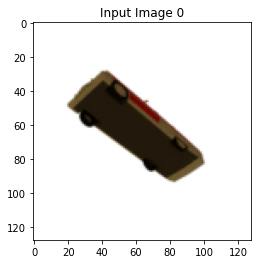

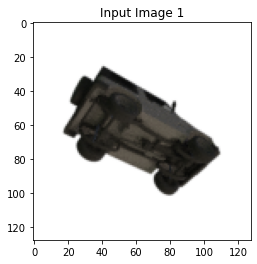

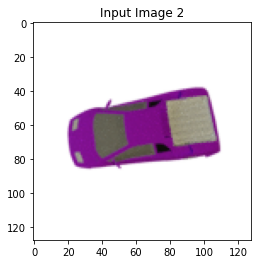

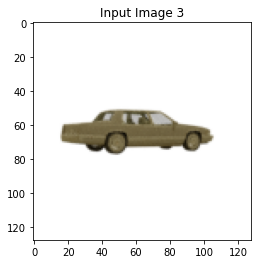

In [9]:
max_iters = 1000
num_views = 1 # How many views to test-time optimize over
lr= 0.5

N_samples = 128
model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))

for i in range(4):
    images, poses, hwf = load_train_ex(test_exs[i], rng)
    
    plt.imshow(images[0])
    plt.title('Input Image '+str(i))
    plt.show()

In [12]:
max_iters = 1000
num_views = 1 # How many views to test-time optimize over
lr= 0.5

N_samples = 128
model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))

for i in range(5):
    test_params, sup_images = train_single_model(max_iters, rng, num_views=num_views, lr=lr, init_params=params, image_idx=i)
    
    images, poses, hwf = load_train_ex(test_exs[i], rng)
    images, test_images = np.split(images, [25], axis=0)
    poses, test_poses = np.split(poses, [25], axis=0)
    
    if num_views == 1:
        plt.imshow(images[0])
        plt.title('Input Image')
        plt.show()
    
    plt.figure(figsize=(15,6))
    for j in range(5):
        test_rays = get_rays(hwf[0], hwf[1], hwf[2], test_poses[j])

        test_result = np.clip(render_fn(random.PRNGKey(0), model, test_params, test_rays, N_samples, rand=False)[0], 0, 1)

        plt.subplot(2,5,j+1)
        plt.imshow(test_images[j])
        plt.title('Target')
        plt.subplot(2,5,j+6)
        plt.imshow(test_result)
        plt.title('Reconstruction')
    plt.show()

KeyboardInterrupt: 

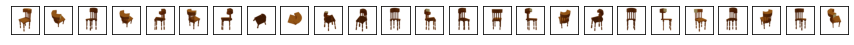

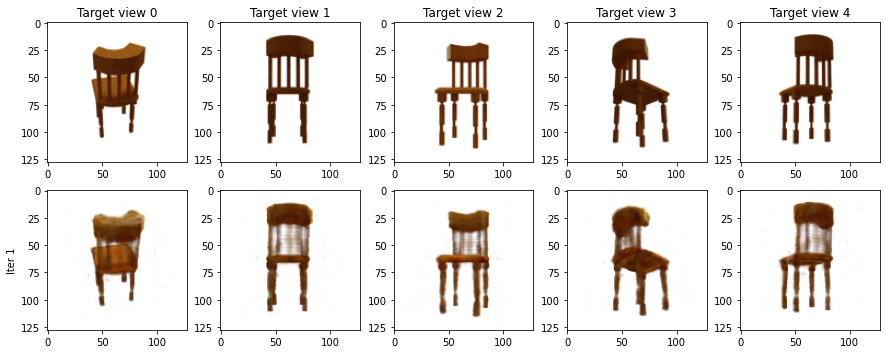

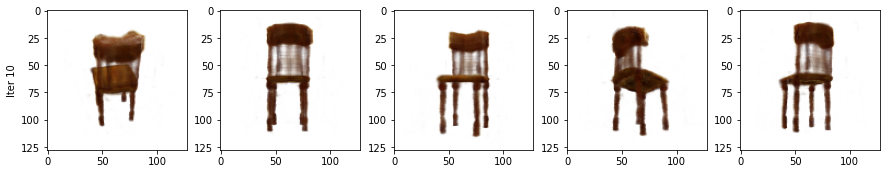

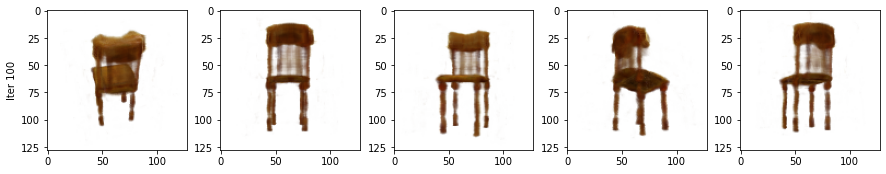

In [27]:
def psnr(gt, pred):
    assert gt.shape == pred.shape
    mse = np.mean((gt-pred)**2)
    psnr = -10 * np.log10(mse)
    return psnr

from time import time
max_iters = [1, 10, 100, 1000, 10000]
num_views = 25 # How many views to test-time optimize over
image_idx = 0
lr= 0.5
timesave = []

N_samples = 128
model = hk.without_apply_rng(hk.transform(lambda x, y=None: Model()(x, y)))


for i in range(len(max_iters)):
    prevtime = time()
    test_params, sup_images = train_single_model(max_iters[i], rng, num_views=num_views, lr=lr, init_params=save_params, image_idx=image_idx)
    timesave.append(time()-prevtime)
    
    images, poses, hwf = load_train_ex(test_exs[image_idx], rng)
    images, test_images = np.split(images, [25], axis=0)
    poses, test_poses = np.split(poses, [25], axis=0)
    
    if i==0:
        if num_views>=5:
            plt.figure(figsize=(15,3))
        else:
            plt.figure(figsize=(3*num_views,3))
        for k in range(num_views):
            plt.subplot(1,num_views,k+1)
            plt.imshow(images[k])
            if k==0:
                plt.ylabel('Input Image')
            ax = plt.gca()
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
        plt.show()
    
    plt.figure(figsize=(15,3*(1+len(max_iters))))
    test_psnr = []
    for j in range(5):
        test_rays = get_rays(hwf[0], hwf[1], hwf[2], test_poses[j])

        test_result = np.clip(render_fn(random.PRNGKey(0), model, test_params, test_rays, N_samples, rand=False)[0], 0, 1)

        if i==0:
            plt.subplot(1+len(max_iters),5,j+1)
            plt.imshow(test_images[j])
            plt.title('Target view '+str(j))
        plt.subplot(1+len(max_iters),5,j+(i+1)*5+1)
        plt.imshow(test_result)
        if j==0:
            plt.ylabel('Iter '+str(max_iters[i]))
        
        test_psnr.append(psnr(test_images[j], test_result))
    # plt.show()
    # test_psnr.append(np.mean(np.array(test_psnr)))
    # print(test_psnr)
    # print("Time: ", timesave)
plt.show()

In [ ]:
save_params = test_params
# reset train_single_model()
# change init_params